In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0607_unigram'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_bd_*.pth')]
len(model_wt_fnames)

29

In [5]:
!grep Clas ./prod/out_fwd_tmp30.txt > ./by_seed_fwd_perf

In [6]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf.head()

,id,acc,F1,rnd_seed
0,Clas RndSeed: 974110,0.855833,0.808465,974110
1,Clas RndSeed: 625561,0.853333,0.806497,625561
2,Clas RndSeed: 903002,0.855556,0.811046,903002
3,Clas RndSeed: 813876,0.859167,0.811741,813876
4,Clas RndSeed: 64525,0.856667,0.813043,64525


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

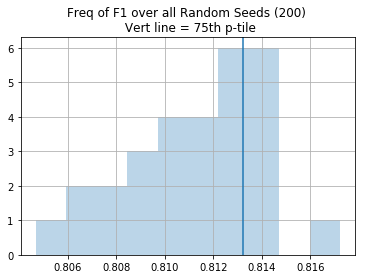

In [7]:
valid_perf.F1.hist(alpha=0.3)
plt.axvline(x=valid_perf.F1.quantile(0.75))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

In [8]:
selected_rnd_seeds = valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].rnd_seed.tolist()

In [11]:
model_wt_fnames = [f'haha_clas_bd_{x}.pth' for x in selected_rnd_seeds]

In [12]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [13]:
np.array(ensemble_preds).shape

(8, 6000, 2)

In [14]:
np.array(ensemble_preds)

array([[[0.188219, 0.811781],
        [0.997719, 0.002281],
        [0.076236, 0.923764],
        [0.935197, 0.064803],
        ...,
        [0.991071, 0.008929],
        [0.935688, 0.064312],
        [0.763841, 0.236159],
        [0.173104, 0.826896]],

       [[0.27887 , 0.72113 ],
        [0.887463, 0.112537],
        [0.049133, 0.950867],
        [0.914154, 0.085846],
        ...,
        [0.695903, 0.304097],
        [0.96248 , 0.03752 ],
        [0.254974, 0.745026],
        [0.229806, 0.770194]],

       [[0.27974 , 0.72026 ],
        [0.909635, 0.090365],
        [0.076918, 0.923082],
        [0.930934, 0.069065],
        ...,
        [0.805898, 0.194102],
        [0.942865, 0.057135],
        [0.471402, 0.528598],
        [0.281978, 0.718022]],

       [[0.136267, 0.863733],
        [0.954988, 0.045012],
        [0.035078, 0.964922],
        [0.934271, 0.065729],
        ...,
        [0.954321, 0.045679],
        [0.930976, 0.069024],
        [0.30551 , 0.69449 ],
        [0.3

In [15]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.215916, 0.784084],
       [0.961612, 0.038388],
       [0.056318, 0.943682],
       [0.926802, 0.073198],
       ...,
       [0.912124, 0.087876],
       [0.931799, 0.068201],
       [0.40502 , 0.59498 ],
       [0.252325, 0.747675]], dtype=float32)

In [16]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [17]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [18]:
out_df.to_csv('sub0608_Unigram_clas.csv',header=True,index=False)